# Tutorial 3: filling methods and saving a project

In this example a simple geological model will be built using MPS, TPG and SIS as filling method. The results will then be saved.

Note : to use MPS, a valid DeeSse license is required (commercial or academic).

In [1]:
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
pv.set_jupyter_backend('static')
import sys

#For loading ArchPy, the path where ArchPy is must be added with sys
sys.path.append("../../")
#my modules
from ArchPy.base import * #ArchPy main functions 
from ArchPy.tpgs import * #Truncated plurigaussians

ArchPy integrates multiple filling method such as Multiple-Point Statistics (MPS), Truncated PluriGaussian (TPG), Sequential Indicator Simulations (SIS) and SubPile which will be showed in another notebook.

In [2]:
P1 = Pile(name="P1",seed=1) #creating the pile

In [3]:
#creating the grid

#grid
sx = 0.15
sy = 0.15
sz = .15
x1 = 20
y1 = 10
z1 = -6
x0 = 0
y0 = 0
z0 = -15
nx = 133
ny = 67
nz = 62

#coordinates vectors
xg = np.linspace(x0,x1,nx+1)
yg = np.linspace(y0,y1,ny+1)
zg = np.linspace(z0,z1,nz+1)

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

#setting a top and a bot
top = np.ones([ny,nx])*-6
bot = np.ones([ny,nx])*z0

**In this example one unit (D) will be simulated with TPG and another (B) with MPS.**

Before creating the units, we can define all the simulation parameters, let's begin with the TPG.
TPG here are the truncation of two gaussian random fields (GRF), this implies that the inputs are a truncation flag (defining how to truncate the GRF) and two covariance models (one for each GRF).

There are some tools to infer the covariance models directly from the indicator variograms but they are not optimum and still in development. Thus, they will be not detailed here.

Below the ``flag`` is defined and the two covariance models also ``G_cm``.

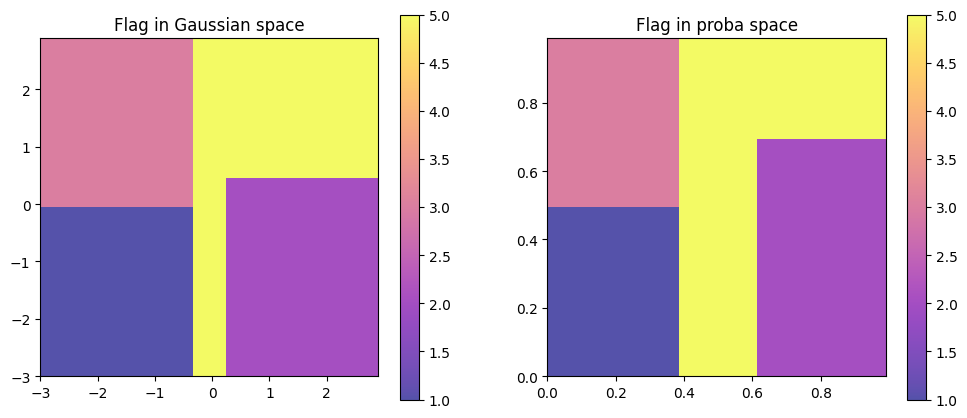

In [4]:
## setup TPGs for D unit

#flag
#thresholds
t2g1 = -0.3
t3g1 = .3
t1g2 = 0
t2g2 = 0.5

#dictionnaries show where a certain facies is present. 
# The structure is a list of list containing 2 tuples of size 2 that indicates the limits of the gaussian fields
# e.g. [[(lower_boundary1_g1,upper_boundary1_g1),(lower_boundary1_g2,upper_boundary1_g2)]] --> this indicates one cuboid and multiple can be defined
dic1 = [[(-np.inf,t2g1),(-np.inf,t1g2)]] # this facies is present between -inf to -0.3 of the 1st gaussian field and between -inf to 0 of the 2
dic2 = [[(t3g1,np.inf),(-np.inf,t2g2)]]
dic3 = [[(-np.inf,t2g1),(t1g2,np.inf)]]
dic4 = [[(t2g1,t3g1),(-np.inf,np.inf)],[(t3g1,np.inf),(t2g2,np.inf)]]

flag = {1:dic1,
        2:dic2,
        3:dic3,
        5:dic4}


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_flag(flag,alpha=.7)
plt.title("Flag in Gaussian space")

plt.subplot(1,2,2)
plot_flag(Gspace2Pspace(flag),alpha=.7)
plt.title("Flag in proba space")

## Gaussian random fields covariance models
G1 = gcm.CovModel3D(elem=[("cubic",{"w":1.,"r":[5.,5.,2.]}),
                         ("nugget",{"w":0.0})],name="G1")
G2 = gcm.CovModel3D(elem=[("spherical",{"w":1.,"r":[10.,10.,5.]}),
                         ("nugget",{"w":0.0})],name="G2",alpha=30)
G_cm = [G1,G2]

**Now we can set up the parameters for the MPS simulations**

First a 3D Training image is necessary. Here some channels. **The values of the TI must match the facies ID** in the unit where the MPS will be done. It is necessary to modify the TI values in consequence. We can use the ``ArchPy.Arr_replace`` function for that.

Secondly, various MPS parameters can be chosen (rotation, homotethy softproba, ...), they are passed directly in the dic_facies of the concerned unit (B here). 

There are many parameters available and if you want to have an exhaustive view of the capabilities of the MPS algorithm (Deesse) you can see [Geone](https://github.com/randlab/geone). ArchPy integrates not all but many of the Deesse parameters.


In [5]:
# load TI
TI_B = "../../data/TIs/channels3D/ti_channels3D_4f_100x100x60.vtk"
TI_B = geone.img.readImageVtk(TI_B)

#in this example B has four facies which have as ID (1,2,3,5)
TI_B.val = Arr_replace(TI_B.val,{0:3,1:1,2:2,3:5})

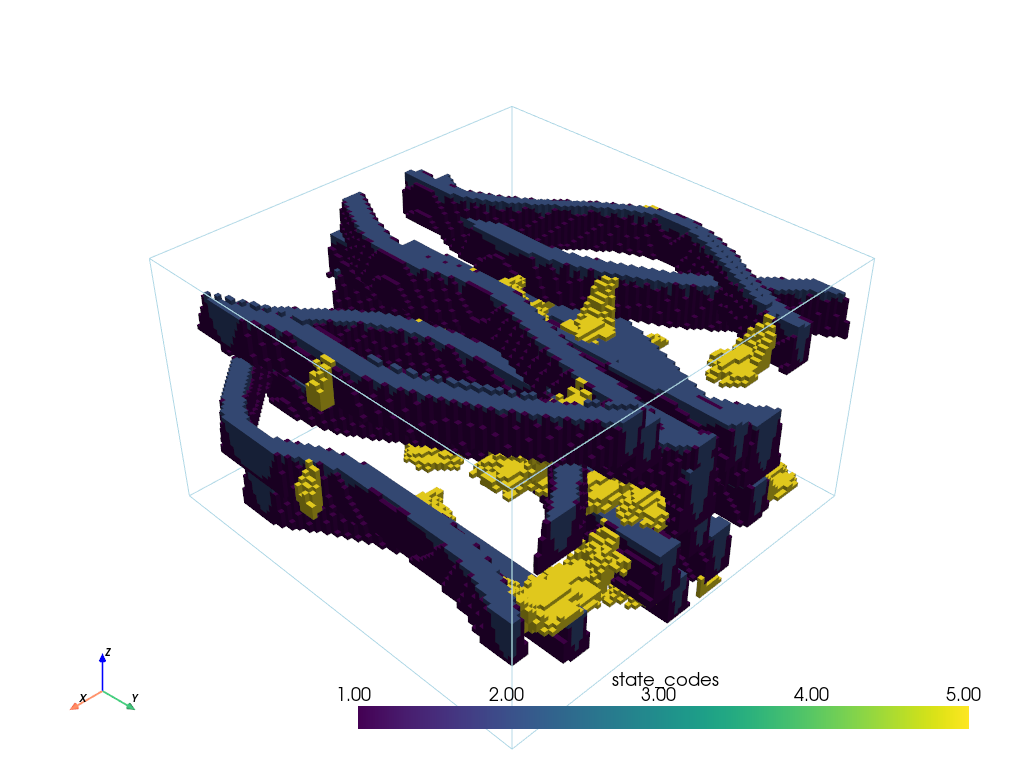

In [6]:
imgplt3.drawImage3D_surface(TI_B, excludedVal=[3])

## Creating the units

### Unit D

In [7]:
#D unit

covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[6,6]})])
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method" : "TPGs","Flag" : flag,"G_cm":G_cm,"grf_method":"sgs"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)


Unit D: Surface added for interpolation


### Unit C

In [8]:
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[8,8]})])
dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC}

covmodel_SIS_C1 = gcm.CovModel3D(elem=[("exponential",{"w":.25,"r":[10,10,3]})],alpha=0,name="vario_SIS") # input variogram
covmodel_SIS_C2 = gcm.CovModel3D(elem=[("exponential",{"w":.21,"r":[20,20,5]})],alpha=45,beta=30,name="vario_SIS") # input variogram
lst_covmodelC=[covmodel_SIS_C1, covmodel_SIS_C2] # list of covmodels to pass at the function

dic_f_C = {"f_method" : "SIS","neig" : 10,"f_covmodel":lst_covmodelC} #facies dic (params)
C = Unit(name="C",
         order=2,
         ID = 2,
         color="blue",
         contact="onlap",
         dic_facies=dic_f_C,
         surface=Surface(dic_surf=dic_s_C,contact="onlap")
        )

Unit C: Surface added for interpolation


### Unit B

Below we create the B unit. 
Used MPS parameters are :

- ``xr``, ``yr``, ``zr`` : x, y and z homotethy ratio. This served to redimensionate the TI to match simulation grid. Little numbers reduce the size of the TI and produce smaller "features".
- ``maxscan`` : The fraction of the TI to scan. This indicates how many the TI will be scanned by Deesse before choosing a value. Setting to lower values increase the speed but reduce the quality of the simulation.
- ``thresh`` : threshold criterion to accept a certain value. This indicates to Deesse at which point we want to respect TI, if ``thresh`` is very low, only values to perfectly match with patterns in the TI will be accepted. Lower values increas the quality but reduce the speed of the sims.
- ``rot_usage`` : flag to indicate to Deesse which method to use for the rotation of the TI
- ``rotAzi`` : Azimuth rotation of the TI. Here 90 simply means that the TI has been turn by a quarter.
- ``probaUsage`` : flag to indicate which method to use for the proba constraints. 1 is for global pdf, 2 for local pdf
- ``globalPdf`` : the global pdf to use if probaUsage is set to 1. Order of the values corresponds to the order of the values in the TI.

For others see ArchPy documentation in Unit description.

In [9]:
#B unit
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[6,6]})])
dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB}
dic_f_B = {"f_method":"MPS", "TI":TI_B, "xr":0.5,"yr":0.5,"zr":0.3, "maxscan":0.1, "thresh":0.05,
           "rot_usage":1, "rotAzi":90, "globalPdf":(0.33,0.37,0.2,0.1),"probaUsage":1}
B = Unit(name="B",
         order=3,
         ID = 3,
         color="green",
         contact="onlap",
         dic_facies=dic_f_B,
         surface=Surface(contact="onlap",dic_surf=dic_s_B)
        )

Unit B: TI added
Unit B: Surface added for interpolation


### Unit A

In [10]:
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[10,10]})])
dic_s_A = {"int_method":"grf_ineq","covmodel": covmodel_er}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",
         order=4,
         ID = 4,
         color="red",
         contact="onlap",
         dic_facies=dic_f_A,
         surface=Surface(dic_surf = dic_s_A,contact="erode"))

Unit A: Surface added for interpolation


### Adding units to Pile


In [11]:
#Master pile
P1.add_unit([D,C,B,A])

Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


## Facies and Properties

In [12]:
#Facies
facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_3 = Facies(ID = 3,name="GM",color="blueviolet")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_5 = Facies(ID = 5,name="SM",color="brown")
facies_6 = Facies(ID = 6,name="Silt",color="goldenrod")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1,facies_2,facies_3,facies_5])
D.add_facies([facies_1,facies_2,facies_3,facies_5])
C.add_facies([facies_4,facies_6])


# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[5,5,1]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[3,3,1]})],alpha=0,name="K_vario_2")
covmodelPoro = gcm.CovModel3D(elem=[("exponential",{"w":0.005,"r":[5,5,5]})],alpha=0,name="poro_vario")

permea = Prop("K",[facies_1,facies_2,facies_3,facies_4,facies_5,facies_6,facies_7],
                  [covmodelK2,covmodelK,covmodelK,None,covmodelK2,covmodelK,None],
                  means=[-3.5,-2,-4.5,-8,-5.5,-6.5,-10],
                  int_method = ["sgs","sgs","sgs","homogenous","sgs","sgs","homogenous"],
                  def_mean=-5)
poro = Prop("Porosity",
            [facies_1,facies_3,facies_4],
            [covmodelPoro,covmodelPoro,covmodelPoro],
             means = [0.4,0.3,0.2],
             int_method = ["sgs","sgs","sgs"],
             def_mean=0.3,
             vmin=0)

Facies basement added to unit A
Facies Sand added to unit B
Facies Gravel added to unit B
Facies GM added to unit B
Facies SM added to unit B
Facies Sand added to unit D
Facies Gravel added to unit D
Facies GM added to unit D
Facies SM added to unit D
Facies Clay added to unit C
Facies Silt added to unit C


## Boreholes

Only Unit data are used

In [13]:
#logs strati
log_strati1 = [(C,-6.01),(B,-8),(A,-10)]
log_strati2 = [(C,-6.01),(B,-8.5),(A,-10.5)]
log_strati3 = [(D,-6.01),(B,-8),(A,-10.5)]
log_strati4 = [(D,-6.01),(B,-9),(A,-11)]
log_strati5 = [(D,-6.01),(C,-10),(A,-12)]
log_strati6 = [(D,-6.01),(A,-9)]

#create boreholes
bh1 = borehole("b1",1,x=1,y=5,z=log_strati1[0][1],depth =9,log_strati=log_strati1)
bh2 = borehole("b2",2,x=3,y=2,z=log_strati2[0][1],depth =8,log_strati=log_strati2)
bh3 = borehole("b3",3,x=5,y=6,z=log_strati3[0][1],depth =7,log_strati=log_strati3)
bh4 = borehole("b4",4,x=10,y=1,z=log_strati4[0][1],depth =8,log_strati=log_strati4)
bh5 = borehole("b5",5,x=15,y=3,z=log_strati5[0][1],depth =8,log_strati=log_strati5)
bh6 = borehole("b6",6,x=19,y=9,z=log_strati6[0][1],depth =6,log_strati=log_strati6)

## Define a domain polygon

Polygon is a 2D array of size ny, nx with values of 0 and 1.
0 is to indicate an area not to be simulated and 1 the inverse.


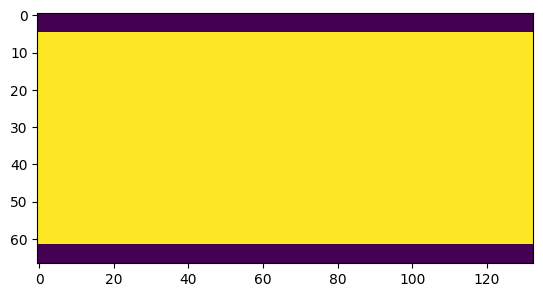

In [14]:
domain = np.ones([ny,nx],dtype=bool)
domain[: 5]= 0
domain[-5:] = 0
plt.imshow(domain)

## Creating project and grid

In [15]:
ws = "3_fillAndSave" #working directory
T1 = Arch_table(name = "Exemple_3",seed=1, working_directory=ws)
T1.set_Pile_master(P1) #setting master pile
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot,polygon=domain) #grid
T1.rem_all_bhs() #remove previous boreholes if any (not useful in this example)
T1.add_bh([bh1,bh2,bh3,bh4,bh5,bh6]) #add boreholes (they are put in a list)
T1.add_prop([permea, poro]) #add properties

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Standard boreholes removed
Fake boreholes removed
Geological map boreholes removed
Borehole 1 goes below model limits, borehole 1 depth cut
Borehole 1 added
Borehole 2 added
Borehole 3 added
Borehole 4 added
Borehole 5 added
Borehole 6 added
Property K added
Property Porosity added


## Processing HDs

In [16]:
T1.process_bhs()

##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set

 ## Computing distributions for Normal Score Transform ##

Processing ended successfully


## Unit simulations

In [17]:
T1.compute_surf(2, fl_top = True)

########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.01606893539428711 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.04993581771850586 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.06008768081665039 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.07364964485168457 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.032235145568847656 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.05434584617614746 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.07589316368103027 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.0704193115234375 s
##########################


### 0.4771730899810791: Total

## Plots

**Plotting units**

ArchPy integrates multiple plotting utilities that mostly rely on Pyvista and Geone.
Below are some examples

In [18]:
pv.set_jupyter_backend('static')

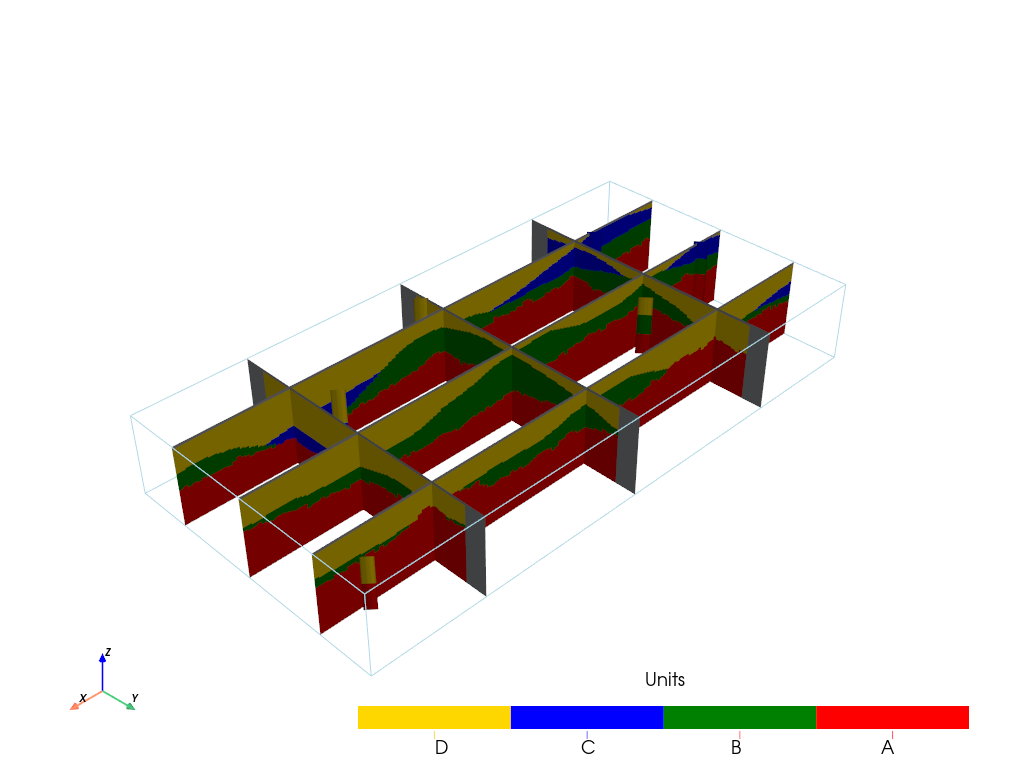

In [19]:
p = pv.Plotter()
v_ex = 0.3

T1.plot_units(0, v_ex=v_ex, plotter=p, slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8))
T1.plot_bhs(plotter=p, v_ex=v_ex)
p.show()

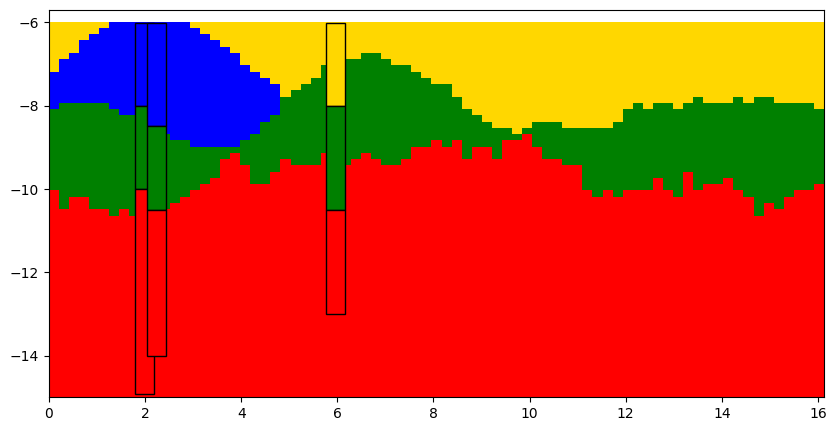

In [20]:
#cross section
#first a list of points must be defined
p1 = [1,1]
p2 = [5,7]
p3 = [15,9]
T1.plot_cross_section([p1,p3],iu=1,ratio_aspect=2, dist_max=4, width=.4)

ArchPy also integrates probability plotting functions which allow to plot any ArchPy object such as units or facies

<div class="alert alert-warning">

Note that MPS simulations are performed using the DEeSse algorithm which requires a license to be used commercially but free to use otherwise.
    
</div>

In [21]:
T1.compute_facies(2, verbose_methods=0)


### Unit D: facies simulation with TPGs method ####
### Unit D - realization 0 ###
### Unit D - realization 1 ###
Time elapsed 3.83 s

### Unit C: facies simulation with SIS method ####
### Unit C - realization 0 ###
### Unit C - realization 1 ###
Time elapsed 4.08 s

### Unit B: facies simulation with MPS method ####
### Unit B - realization 0 ###
### Unit B - realization 1 ###
Time elapsed 302.46 s

### Unit A: facies simulation with homogenous method ####
### Unit A - realization 0 ###
### Unit A - realization 1 ###
Time elapsed 0.05 s

### 310.42: Total time elapsed for computing facies ###


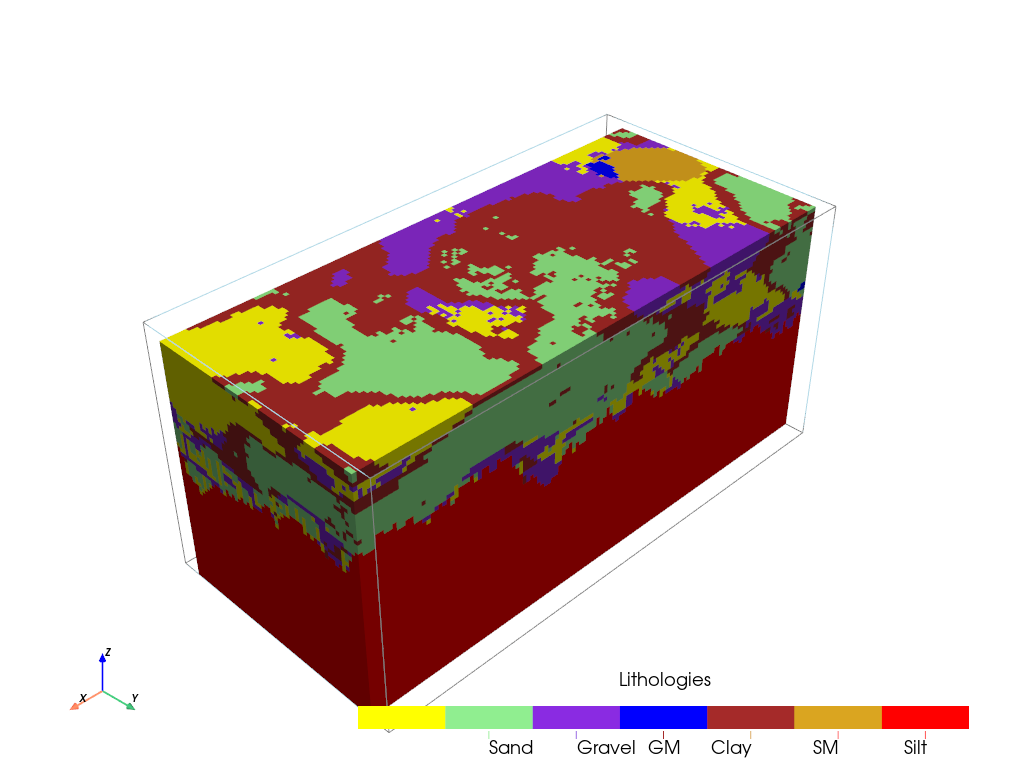

In [22]:
T1.plot_facies(v_ex=1)

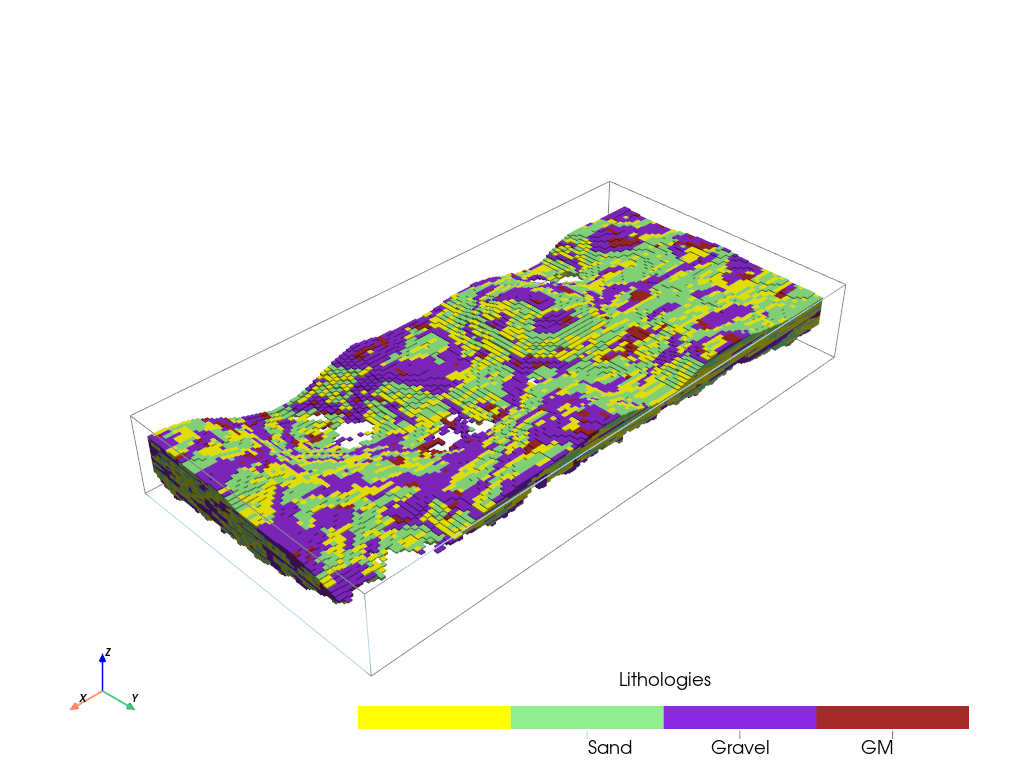

In [23]:
T1.plot_facies(1,0,inside_units=[B], v_ex=v_ex)

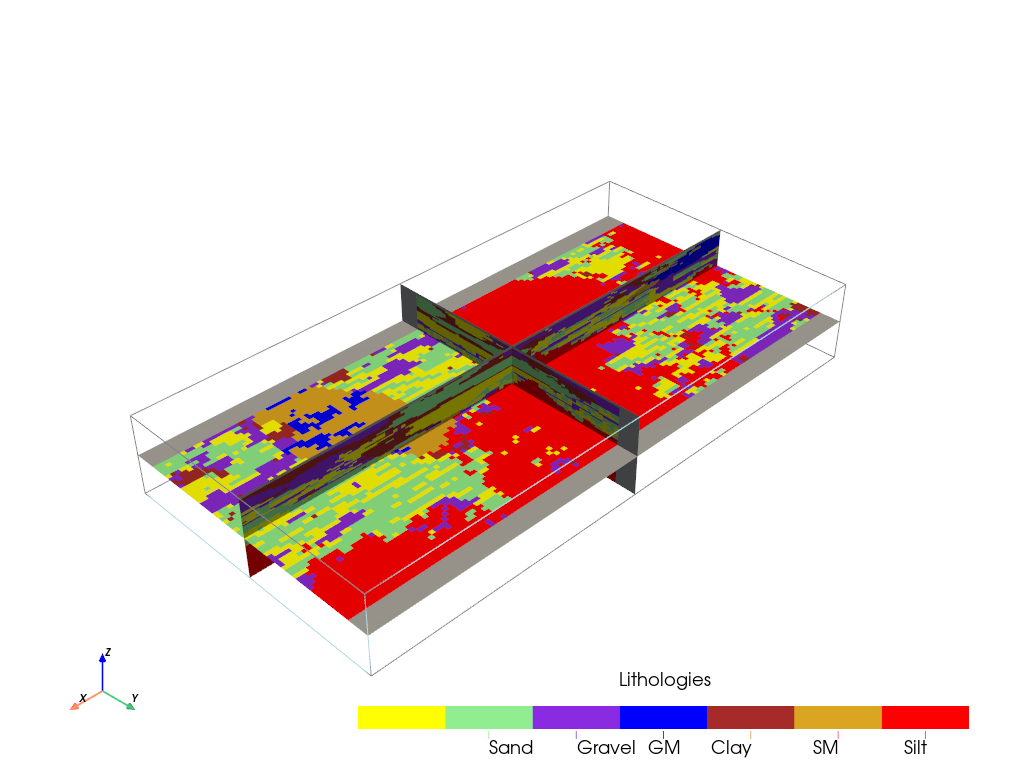

In [24]:
T1.plot_facies(1,0, v_ex=v_ex, slicex=0.5,slicey=0.5,slicez=0.5)

In [25]:
T1.compute_prop(5)

### 20 K property models will be modeled ###
### 5 K models done
### 10 K models done
### 15 K models done
### 20 K models done
### 20 Porosity property models will be modeled ###
### 5 Porosity models done
### 10 Porosity models done
### 15 Porosity models done
### 20 Porosity models done


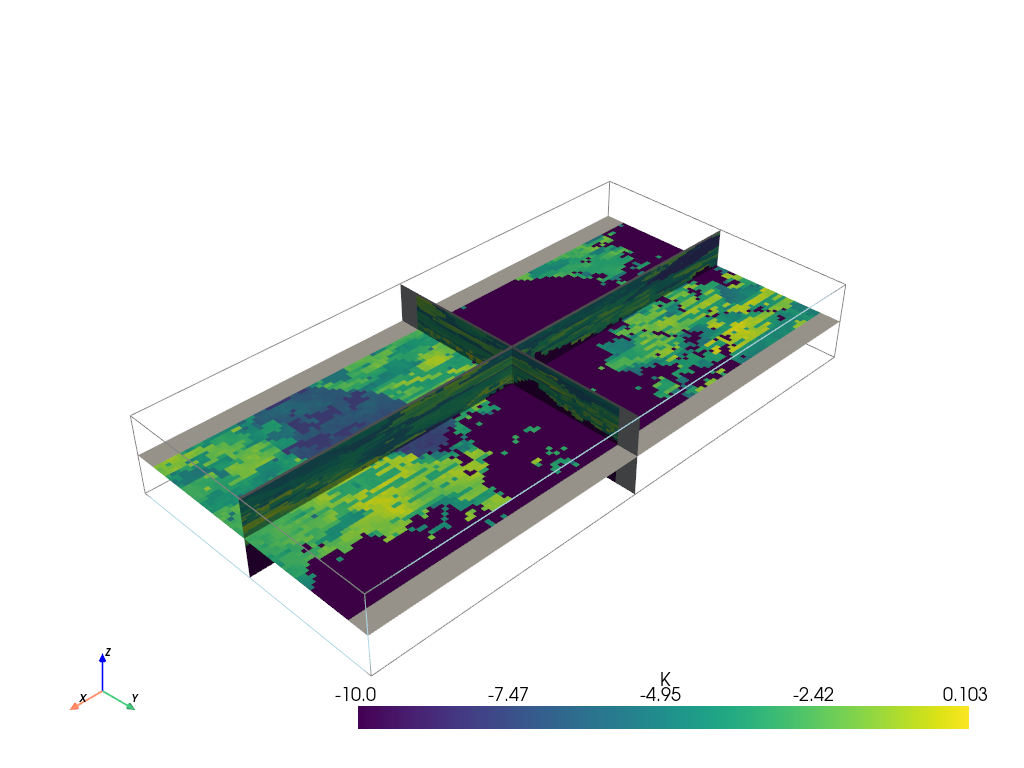

In [26]:
T1.plot_prop(permea.name,1, slicex=0.5,slicey=0.5,slicez=0.5, v_ex=v_ex)

M:\GitHub\ArchPy\examples\01_basic\../..\ArchPy\base.py:5301: RuntimeWarning: Mean of empty slice
  arr=np.nanmean(prop.reshape(-1,self.get_nz(),self.get_ny(),self.get_nx()),axis=0)


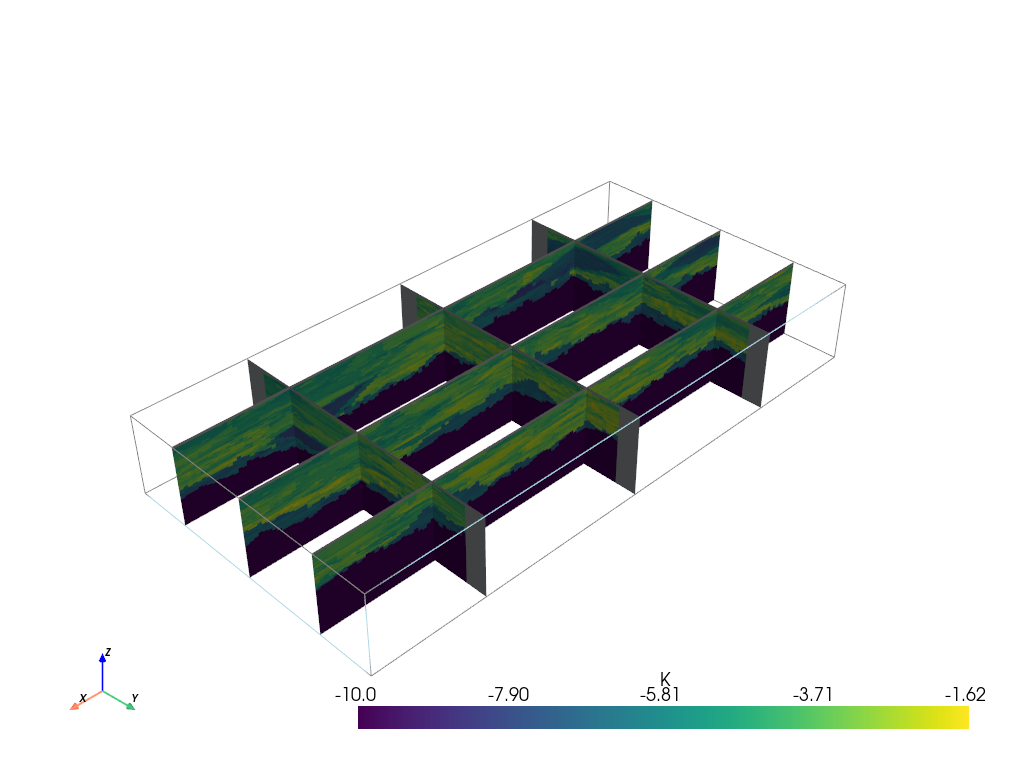

In [27]:
T1.plot_mean_prop("K", slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8), v_ex=v_ex)

M:\GitHub\ArchPy\examples\01_basic\../..\ArchPy\base.py:5301: RuntimeWarning: Mean of empty slice
  arr=np.nanmean(prop.reshape(-1,self.get_nz(),self.get_ny(),self.get_nx()),axis=0)


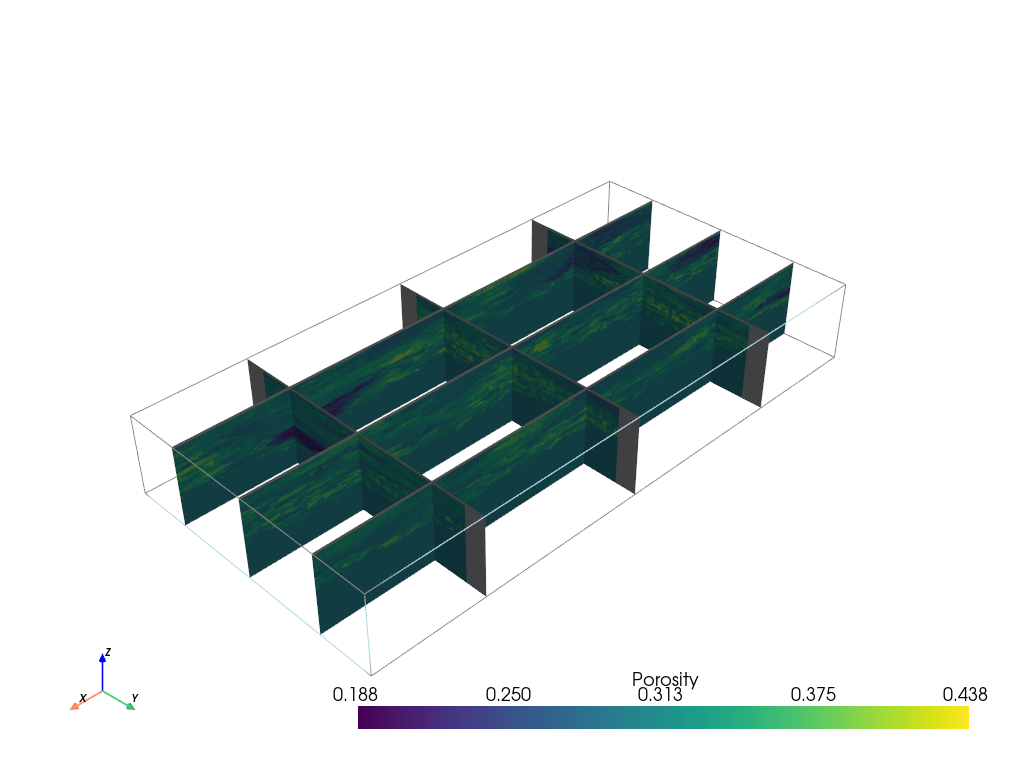

In [28]:
T1.plot_mean_prop("Porosity", slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8), v_ex=v_ex)

## Saving results

ArchPy supports the saving of the results and the inputs parameters. This is done using pickle in binary files to save space. There is five results files differentiated by their file extension:
- ``.sf`` : top surface results. They are stored as values in a dictionnary where keys are the different Piles used (especially if more than 1 level of hierarchy is used). Surfaces are then attached to the Piles where their unit belongs.
- ``.sfb`` : identical to ``.sf`` except that these are botom surfaces.
- ``.unt`` : units domains realizations (nreal_units, nz, ny, nx) where values are units ID.
- ``.fac`` : facies domains realizations (nreal_units, nreal_facies, nz, ny, nx) where values are facies ID.
- ``.pro`` : property simulations dictionnary with prop name as keys and values are nd array --> (nreal_units, nreal_facies, nreal_prop, nz, ny, nx).

Finally, inputs parameters (i.e. the whole Stratigraphic Pile) are stored in a yaml file.

This is simply done by using the ``ArchPy.inputs.save_project`` function.

In [29]:
ArchPy.inputs.save_project(T1)

Project saved successfully


True

In [30]:
#list of files
os.listdir("3_fillAndSave/")

['B_dic_facies_TI.gslib',
 'Exemple_3.bot.npy',
 'Exemple_3.fac',
 'Exemple_3.fd',
 'Exemple_3.lbh',
 'Exemple_3.msk.npy',
 'Exemple_3.pro',
 'Exemple_3.sf',
 'Exemple_3.sfb',
 'Exemple_3.top.npy',
 'Exemple_3.ud',
 'Exemple_3.unt',
 'Exemple_3.yaml',
 'fake_Exemple_3.fd',
 'fake_Exemple_3.lbh',
 'fake_Exemple_3.ud']

If we inspect the files inside the working directory (**ws**) we can see that many files have been created. Indeed this function everything. For example, the first object is the TI, as ArchPy doesn't know where is the original file, it prefers to create a new one and store it in the **ws**.

ArchPy stores simple informations in the ``project_name.yaml`` file and larger or complex data (nd array, geone image, ...) into external files.

e.g. :
- Grid has also been stored where top and bot are `.npy` files. 
- Boreholes files are also stored (``.lbh``, ``.fd`` and ``.ud``).

Let's see now what is inside the yaml file.

In [31]:
import yaml #requires yaml 
from yaml import Loader

with open(os.path.join(T1.ws,T1.name+".yaml"), "r") as f:
    yaml_file = yaml.load(f, Loader=Loader)

We see that all the objects, parameters are stored in a text format. 

Ongoing work is done to load these parameters automatically which will allow to create ArchPy files externally to python. However, it is possible to load results already with ``ArchPy.inputs.load_results`` but this requires an ArchTable project.


In [32]:
yaml_file

{'Facies': {'Clay': {'ID': 4, 'color': 'blue'},
  'GM': {'ID': 3, 'color': 'blueviolet'},
  'Gravel': {'ID': 2, 'color': 'lightgreen'},
  'SM': {'ID': 5, 'color': 'brown'},
  'Sand': {'ID': 1, 'color': 'yellow'},
  'Silt': {'ID': 6, 'color': 'goldenrod'},
  'basement': {'ID': 7, 'color': 'red'}},
 'Pile_master': 'P1',
 'Piles': {'P1': {'list_units': ['D', 'C', 'B', 'A'],
   'name': 'P1',
   'seed': 1,
   'verbose': 1}},
 'Results': {'facies': 'Exemple_3.fac',
  'properties': 'Exemple_3.pro',
  'surfaces': 'Exemple_3.sf',
  'surfaces_bot': 'Exemple_3.sfb',
  'units': 'Exemple_3.unt'},
 'Units': {'A': {'ID': 4,
   'color': 'red',
   'dic_facies': {'f_method': 'homogenous'},
   'list_facies': ['basement'],
   'name': 'A',
   'order': 4,
   'surface': {'contact': 'erode',
    'dic_surf': {'N_transfo': False,
     'bandwidth_mult': 1,
     'covmodel': {'alpha': 0.0,
      'elem': [('spherical', {'r': [10.0, 10.0], 'w': 1.0})]},
     'int_method': 'grf_ineq',
     'tau': 0},
    'name': 'Sur

**This concludes this notebook about filling methods and saving methods**